In [12]:
import saxtal_functions as sax
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
filename = 'test_image_bin_2.mrc'
threshold_method = 'sd'
verbose = True
threads = 12
sigma = 9
quantile=0.9999
num_sd = 3.0
x_window_percent=(0.005, 0.7)
y_window_percent=(0.005, 0.7)

# spare the ice ring
# x_window_percent=(0.005, 0.4)
# y_window_percent=(0.005, 0.2)

replace_distance_percent=0.05

In [ ]:
# Handy utility to inspect source of a function.

# import inspect
# lines = inspect.getsource(sax.scipy_fft)
# print(lines)

In [ ]:
sax.mask_image(filename, 
               threshold_method='sd', 
               verbose=True, 
               threads=12, 
               sigma=9, 
               num_sd=3.0, 
               x_window_percent=(0.005,0.4), 
               y_window_percent=(0.005,0.2), 
               mask_hotpixels=False,
               replace_distance_percent=0.05)

In [3]:
image, header = sax.import_mrc(filename)

In [4]:
padded_fft = sax.scipy_fft(image, verbose, 12)

scipy_fft(): FFT performed in 162.28 milliseconds.


In [5]:
padded_fft.shape

(5760, 2881)

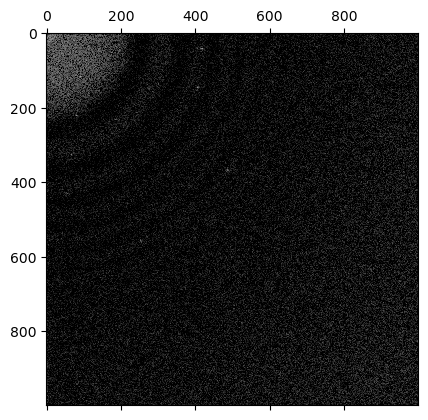

In [6]:
plt.matshow(np.log10(np.abs(padded_fft))[:1000, :1000],
           cmap = "Greys_r",
           vmax = 5,
           vmin = 2.5)

In [7]:
diff_spectrum, smoothed_spectrum = sax.generate_diff_spectrum(padded_fft, sigma)

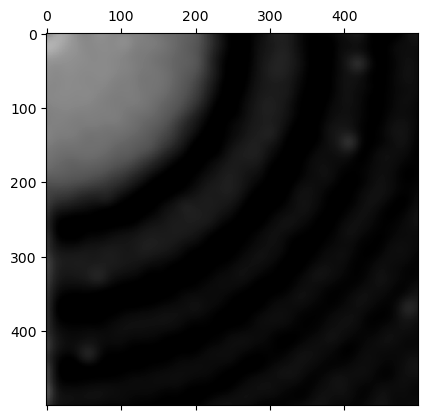

In [8]:
plt.matshow(np.log10(np.abs(smoothed_spectrum))[:500, :500],
           cmap = "Greys_r",
           vmax = 4,
           vmin = 2.5)

/tmp/ipykernel_685323/1207827433.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(np.abs(diff_spectrum))[350:450, 400:500],


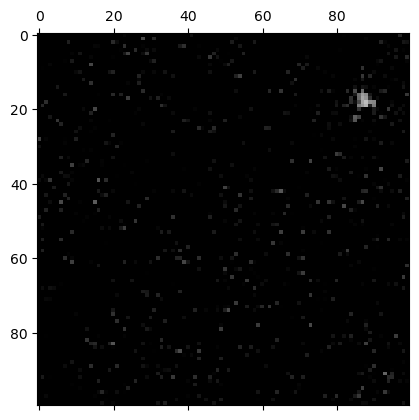

In [9]:
plt.matshow(np.log10(np.abs(diff_spectrum))[350:450, 400:500],
           cmap = "Greys_r",
           vmax = 4,
           vmin = 2.5)

In [10]:
diffraction_spots = sax.find_diffraction_spots_sd(diff_spectrum, 
                                                  num_sd, 
                                                  x_window_percent, 
                                                  y_window_percent)

In [14]:
def remove_hotpixels(diffraction_spots):
    """
    Removes isolated "hot" pixels that exceed amplitude threshold but
    have no immediate neighbours, so are likely not part of the
    reciprocal lattice.
    """
    filter_list = []
    for ex_spot in tqdm(diffraction_spots):
        y_neighbours = np.sum((diffraction_spots == (ex_spot[0]+1, ex_spot[1])).all(axis=1)) + np.sum((diffraction_spots == (ex_spot[0]-1, ex_spot[1])).all(axis=1))
        x_neighbours = np.sum((diffraction_spots == (ex_spot[0], ex_spot[1]+1)).all(axis=1)) + np.sum((diffraction_spots == (ex_spot[0]-1, ex_spot[1]-1)).all(axis=1))
        if x_neighbours >= 1 and y_neighbours >= 1:
            filter_list.append(True)
        else: 
            filter_list.append(False)
    return(filter_list)

In [15]:
filtered_spots = remove_hotpixels(diffraction_spots)

100%|████████████████████████████████████| 56229/56229 [02:59<00:00, 312.90it/s]


In [ ]:
filtered = diffraction_spots[filtered_spots]

In [ ]:
plt.scatter(y = -diffraction_spots[:,0], x = diffraction_spots[:,1],
            s = 1)
plt.xlim((20, 2000))
plt.ylim((-4000, -25))

In [ ]:
plt.scatter(y = -filtered[:,0], x = filtered[:,1],
            s = 1)
plt.xlim((25, 500))
plt.ylim((-500, -25))

In [ ]:
filtered